# Computational Soccer Shot Analysis 

OBJECTIVE: Find parameters of shots that lead to goals using shooting algothrim and exhaustive parameter scan

By: Kacey Clark and Christian Burgoyne

### Background



In [3]:
import numpy as np
import pandas as pd

import ode

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

Should be at least 3 pages long

First, define a shooting alogthim function in terms of 

    rho = air density
    
    g = Accl due to gravity
    
    m = mass 
    
    D = diameter 
    
    v0 = speed 
    
    omega = spin (the axis of rotation is perpentidular with the ground)
    
    phi = azimuthal angle (horivantal angle)
    
    Theta = elevation angle (vertical angle)
    
[inspiration can be taken from the baseball homework, hw 7]

Second, set up enviroemnts with proper dimensions for the two different types of kicks, including the goal and its target area. 
    1. free kick 
    2. corner kick

Third, run shooting alogthim through range of paramters. 

In [102]:
rho = 1.2     # kg m^-3
g= 9.81     # kg m s^-2
m = 0.436    # kg
D = 0.218     # m
r = D/2
A = np.pi*r**2
v0s = np.arange(24, 30.1, .1)   # m s^-1
omegas = np.arange(0, 75.6, .2)   # rad s^-1

In [103]:
#parameters for free kick
fphis = np.arange(-0.0349066, 0.0872665, .001)  # rad [-2 deg to 5 deg]
fthetas = np.arange(.174533, 0.349066, .001) # rad [10 deg to 20 deg]

In [104]:
#parameters for corner kick
cphis = np.arange(-0.0698132, 0.0698132, .001)  # rad [-4 deg to 4 deg]
cthetas = np.arange(0.349066, 0.523599, .001) # rad [20 deg to 30 deg]

Objectives
 1. talk about drag and lift coeffcients of ball
 2. simulate trajectories of free kick and corner kick
 3. plot in 2D and 3D and desricbe paramters of trajectories
 4. Talk in depth about at one goal scoring shot for each: include parameters plots and a plot where omega = 0 to show influence of spin.

trajectory of free kick should stop calculating when
  1. ball reaches goal line
  2. ball touches ground
  3. ball touches wall

trajectory of corner kick should stop calculating when
  1. ball reaches goal line
  2. ball touches ground

Possbily use 3D-plotting to show trajectories of shots. (especally goal-making shots). guidense can come from 14_PDEs_2.ipynb

include refences and acknolegdments 


In [7]:
vcrit = 12.19
vs = 1.309

In [8]:
def F_G(m):
    return -m*g

def C_D(v, S):
    if np.linalg.norm(v) < np.linalg.norm(vcrit) or S < .005:
        return .155 + .346/(1+np.e**((v-vcrit)/vs))
    else:
        return .4127*S**.3056

def F_D(v, S):
    return -1/2*C_D(v, S)*rho*A*np.linalg.norm(v)*v

def C_L(S):
    a = 1/2*S**.4
    return a

def F_M(omega, v, S):
    C_L = 1/2*S**.4
    return 1/2*C_L*rho*A*np.linalg.norm(v)/np.linalg.norm(omega)*np.cross(omega, v)

In [64]:
def simulate_soccerball(v0, omega, r0, goalpos=np.array([0,0,0]),
                        goalwidth=7.32, goalheight=2.44,
                        h=0.01, g=9.81, rho=1.2, r=0.109, m=0.436,
                        stupidwall=False, wallpos=np.array([-9.16, 0, 0]),
                        wallheight=1.83):
    """simulate soccerball pitch

    Parameters
    ----------
    v0 : array
         initial velocity (vx, vy, vz) in m/s
    omega : array
         angular velocity vector of the ball ("spin"), in rad/s
    r0 : array
         initial position of the ball (in m) when it leaves
         as (x, y)
    goalpos : array, optional
         position of goal
    goalwidth : float, optional
         width of goal
    goalheight : float, optional
         height of goal
    h : float, optional
         integration time step in s, default is 0.01 s
    g : float, optional
         acceleration due to gravity, default 9.81 kg/(m*s^2)
    rho : float, optional
         density of air, default 1.225 kg/m^3
    r : float, optional
         radius of the soccerball
    m : float, optional
         mass of the soccerball
    stupidwall : boolean
         if there is a wall 3 m wide not centered with the goal because logic?
    wallpos : array
         position of maybe wall

    Returns
    -------

    positions : array
         The array contains an entry (time, x, y, z) for each time step.
    """
    # all SI units (kg, m)

    goal=False

    theta = np.arctan(v0[2]/np.sqrt(v0[0]**2+v0[1]**2))
    phi = np.arctan(v0[1]/v0[0])
    omegamag = np.linalg.norm(omega)
    A = np.pi*r**2
    a_G = np.array([0, -g, 0])

    def f(t, y):
        # y = [x, y, z, vx, vy, vz]
        v = y[3:]
        vmag = np.linalg.norm(v)
        S = r*omegamag/vmag
        a_M = F_M(omega, v, S)/m
        a_D = F_D(v, S)/m
        a = a_G + a_D + a_M
        return np.array([y[3], y[4], y[5],
                         a[0], a[1], a[2]])

    x0, y0, z0 = r0
    vx, vy, vz = v0
    t = 0
    positions = []
    # initialize 3D!
    y = np.array([x0, y0, z0, vx, vy, vz], dtype=np.float64)
    if not stupidwall:
        while y[0] < goalpos[0] and y[2] >= 0 and abs(y[1]) <= 34.26:
            if y[2] < 0:
                y[2] = 0
            positions.append([t, y[0], y[1], y[2]])  # record t, x and y, z
            y[:] = ode.rk4(y, f, t, h)
            t += h
            if y[1] > goalpos[1] and y[1] < goalpos[1]+goalwidth/2 and y[2] > 1.22 and y[2] < goalheight:
                goal = True
                break

    elif stupidwall:
        while y[0] < goalpos[0] and y[2] >= 0 and abs(y[1]) <= 34.26 and not (y[0] == wallpos[0] and y[1] > wallpos[1]-1 and y[1] < wallpos[1]+2 and y[2] > wallpos[2] and y[2] < wallpos[2]+wallheight):
            positions.append([t, y[0], y[1], y[2]])  # record t, x and y, z
            y[:] = ode.rk4(y, f, t, h)
            t += h
            if y[1] > goalpos[1]+1.83 and y[1] < goalpos[1]+goalwidth/2 and y[2] > 1.22 and y[2] < goalheight:
                goal = True
                break

    return np.array(positions), goal

## Free Kick

In [99]:
positions, goal = simulate_soccerball(np.array([26, 0, 3]), np.array([0, 0, 30]), (-18.3, 0, 0), stupidwall=True)

In [100]:
goal

False

<IPython.core.display.Javascript object>


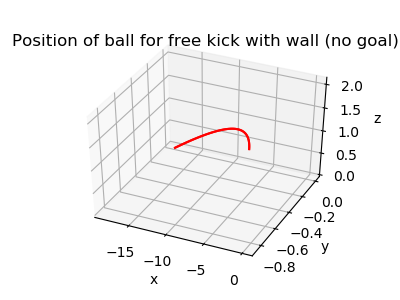

In [101]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Position of ball for free kick with wall (no goal)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Axes3D.plot(ax, positions[:,1], positions[:,2], zs=positions[:,3],c=(1,0,0))
Axes3D.plot(ax, positions[:,1], positions[:,2], zs=positions[:,3],c=(1,0,0))

ax.view_init(elev=40, azim=-65)

In [105]:
ps = []
gs = []
for v0 in v0s:
    for omega in omegas:
        for theta in fthetas:
            for phi in fphis:
                x = v0*np.cos(phi)
                y = v0*np.sin(phi)
                z = np.sqrt(v0**2-x**2-y**2)
                v = np.array([x, y, z])
                positions, goal = simulate_soccerball(v, np.array([0, 0, omega]), (-18.3, 0, 0), stupidwall=True)
                ps.append(positions)
                gs.append(goal)

/home/kreidy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


NameError: name 'goals' is not defined

<IPython.core.display.Javascript object>


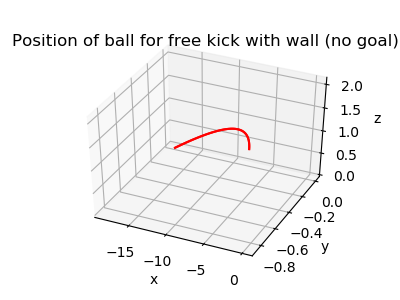

In [101]:
for g, positions in enumerate(ps):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Position of ball for free kick with wall (goal='+str(gs[g])+')')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    Axes3D.plot(ax, positions[:,1], positions[:,2], zs=positions[:,3],c=(1,0,0))
    Axes3D.plot(ax, positions[:,1], positions[:,2], zs=positions[:,3],c=(1,0,0))

    ax.view_init(elev=40, azim=-65)

## Corner Kick

In [84]:
positions, goal = simulate_soccerball(np.array([22, 6, 3]), np.array([0, 0, 30]), (0, -34.26, 0), stupidwall=False)

In [91]:
goal

False

<IPython.core.display.Javascript object>


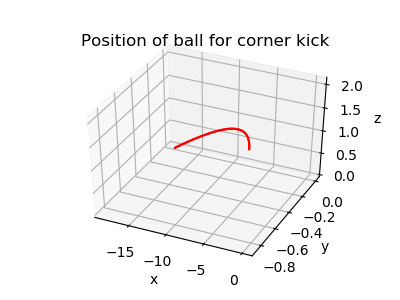

In [93]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Position of ball for corner kick (no goal)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Axes3D.plot(ax, positions[:,1], positions[:,2], zs=positions[:,3],c=(1,0,0))
Axes3D.plot(ax, positions[:,1], positions[:,2], zs=positions[:,3],c=(1,0,0))

ax.view_init(elev=40, azim=-65)

In [105]:
ps = []
gs = []
for v0 in v0s:
    for omega in omegas:
        for theta in fthetas:
            for phi in fphis:
                x = v0*np.cos(phi)
                y = v0*np.sin(phi)
                z = np.sqrt(v0**2-x**2-y**2)
                v = np.array([x, y, z])
                positions, goal = simulate_soccerball(v, np.array([0, 0, omega]), (0, -34.26, 0), stupidwall=False)
                ps.append(positions)
                gs.append(goal)

/home/kreidy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


NameError: name 'goals' is not defined

<IPython.core.display.Javascript object>


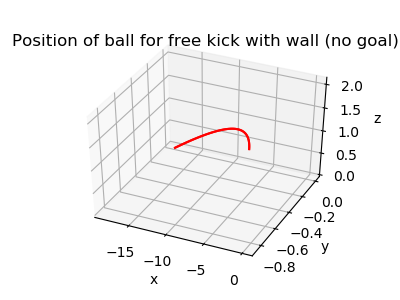

In [101]:
for g, positions in enumerate(ps):
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Position of ball for corner kick (goal='+str(gs[g])+')')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    Axes3D.plot(ax, positions[:,1], positions[:,2], zs=positions[:,3],c=(1,0,0))
    Axes3D.plot(ax, positions[:,1], positions[:,2], zs=positions[:,3],c=(1,0,0))

    ax.view_init(elev=40, azim=-65)

### Results and Discussion

